In [1]:
import pandas as pd
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import ast

In [119]:
import warnings

# SettingWithCopyWarning 경고 무시
pd.set_option('mode.chained_assignment', None)

# FutureWarning 경고 무시
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
accounts_school  = pd.read_csv('./dumps/processed_csv/processed_accounts_school.csv')
accounts_user_contacts  = pd.read_csv('./dumps/processed_csv/processed_accounts_user_contacts.csv')
accounts_user = pd.read_csv('./dumps/processed_csv/processed_accounts_user.csv')
accounts_userquestionrecord = pd.read_csv('./dumps/processed_csv/processed_userquestionrecord.csv')
polls_questionset = pd.read_csv('./dumps/processed_csv/processed_polls_questionset.csv')
accounts_paymenthistory = pd.read_csv('./dumps/processed_csv/processed_accounts_paymenthistory.csv')

accounts_failpaymenthistory = pd.read_csv('./dumps/processed_csv/processed_accounts_failpaymenthistory.csv')

accounts_group = pd.read_csv('./dumps/processed_csv/processed_accounts_group.csv')
accounts_attendance = pd.read_csv('./dumps/votes_csv/accounts_attendance.csv')

## 전처리

### 테이블

In [3]:
# user_id 개별 처리 (str로 바꿔줌)

accounts_user['user_id'] = accounts_user['user_id'].astype(str)
accounts_user['group_id'] = accounts_user['group_id'].astype(str)

accounts_school['id'] = accounts_school['id'].astype(str)
accounts_group['group_id'] = accounts_group['group_id'].astype(str)
accounts_group['school_id'] = accounts_group['school_id'].astype(str)

accounts_paymenthistory['user_id'] = accounts_paymenthistory['user_id'].astype(str)
accounts_failpaymenthistory['user_id'] = accounts_failpaymenthistory['user_id'].astype(str)

accounts_user_contacts['user_id'] = accounts_user_contacts['user_id'].astype(str)
polls_questionset['user_id'] = polls_questionset['user_id'].astype(str)
accounts_userquestionrecord['user_id'] = accounts_userquestionrecord['user_id'].astype(str)
accounts_userquestionrecord['chosen_user_id'] = accounts_userquestionrecord['chosen_user_id'].astype(str)

accounts_attendance['user_id'] = accounts_attendance['user_id'].astype(str)

In [4]:
# id 컬럼명 변경
accounts_school.rename(columns={'id': 'school_id'}, inplace=True)

# 컬럼 데이터 타입 변환
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(ast.literal_eval)

# 리스트 펼쳐진 새로운 df 생성
new_attendance = accounts_attendance.explode('attendance_date_list')

# user_contacts의 id drop
accounts_user_contacts.drop(columns='id', inplace=True)
new_attendance.drop(columns='id', inplace=True)

accounts_paymenthistory['product_hearts'] = accounts_paymenthistory['productId'].apply(lambda x: x.split('.')[1])
accounts_paymenthistory['product_hearts'] = accounts_paymenthistory['product_hearts'].astype(int)

In [5]:
# datetime 변환
accounts_user['created_at'] = pd.to_datetime(accounts_user['created_at']).dt.floor('s')
polls_questionset['created_at'] = pd.to_datetime(polls_questionset['created_at']).dt.floor('s')
accounts_paymenthistory['created_at'] = pd.to_datetime(accounts_paymenthistory['created_at']).dt.floor('s')
accounts_userquestionrecord['created_at'] = pd.to_datetime(accounts_userquestionrecord['created_at']).dt.floor('s')

new_attendance['attendance_date_list'] = pd.to_datetime(new_attendance['attendance_date_list']).dt.floor('s')

### 퍼널

In [6]:
# 날짜 조건 생성
funnel_user_cond = (accounts_user['created_at'] >= '2023-05-13') & (accounts_user['created_at'] <= '2024-05-07')
funnel_questionset_cond = (polls_questionset['created_at'] >= '2023-05-13') & (polls_questionset['created_at'] <= '2024-05-07')
funnel_paymenthistory_cond = (accounts_paymenthistory['created_at'] >= '2023-05-13') & (accounts_paymenthistory['created_at'] <= '2024-05-07')
funnel_question_cond = (accounts_userquestionrecord['created_at'] >= '2023-05-13') & (accounts_userquestionrecord['created_at'] <= '2024-05-07')
funnel_attendance_cond = (new_attendance['attendance_date_list'] >= '2023-05-13') & (new_attendance['attendance_date_list'] <= '2024-05-07')

# 날짜 필터링 - 퍼널 df 생성
funnel_user = accounts_user[funnel_user_cond]
funnel_questionset = polls_questionset[funnel_questionset_cond]
funnel_payment = accounts_paymenthistory[funnel_paymenthistory_cond]
funnel_question = accounts_userquestionrecord[funnel_question_cond]
funnel_attendance = new_attendance[funnel_attendance_cond]

## 퍼널 단계

In [7]:
user_columns = ['user_id', 'group_id']
group_columns = ['group_id', 'school_id', 'is_active']

signup = pd.merge(funnel_user[user_columns], accounts_group[group_columns], on='group_id', how='left')
signup = signup[signup['is_active'] == 1]
signup_user = signup['user_id'].unique()

print(f'유입 유저 수: {len(signup_user)}')

유입 유저 수: 301884


In [8]:
question = funnel_question[funnel_question['user_id'].isin(signup_user)]
orig_question_passive_user = question['chosen_user_id'].unique()
question_active_user = question['user_id'].unique()


print(f'능동적 유저: {len(question_active_user)}\
      \n수동적 유저 (오리지널): {len(orig_question_passive_user)}')
print('---------------------------')

# 먼저 합침
question_all_user = np.append(orig_question_passive_user, question_active_user)
print(f'중복제거 전: {len(question_all_user)}')

# unique()로 중복 제거함
question_total_user = np.unique(question_all_user)
print(f'중복제거 후: {len(question_all_user)}')
print('---------------------------')
print(f'참여 유저 수: {len(question_total_user)}')

능동적 유저: 1705      
수동적 유저 (오리지널): 6076
---------------------------
중복제거 전: 7781
중복제거 후: 7781
---------------------------
참여 유저 수: 6095


In [9]:
# 능동, 수동 유저 분리
# 능동, 수동 중복되는 사람 -> 능동으로 볼 수 있음
# 교집합 사람들을 먼저 구하기

question_intersection_df = pd.DataFrame({
    'user_id': question_all_user
})
question_intersection_df = question_intersection_df['user_id'].value_counts(ascending=False).reset_index(name='user_counts')
question_intersection_df = question_intersection_df[question_intersection_df['user_counts'] > 1]

question_intersection_user = question_intersection_df['user_id'].unique()
print(f'교집합 유저 수: {len(question_intersection_user)}')
print(f'능동 유저 중 교집합 유저 비율(%): {round(len(question_intersection_user) / len(question_active_user) * 100, 2)}')

교집합 유저 수: 1686
능동 유저 중 교집합 유저 비율(%): 98.89


In [10]:
# 능동 유저에 이미 교집합 유저가 포함되어 있을태니
# 수동 유저에서 교집합 유저를 뺌
question_passive_df = pd.DataFrame({
    'user_id': orig_question_passive_user
})
question_passive_df = pd.merge(question_passive_df, question_intersection_df, on='user_id', how='left')
question_passive_df.isnull().sum() # null값 있음. null 값을 가지고 있는 유저들이 수동 유저
question_passive_df = question_passive_df[question_passive_df['user_counts'].isnull()]

question_passive_user = question_passive_df['user_id'].unique()
print(f'수동적 유저 수: {len(question_passive_user)}')

수동적 유저 수: 4390


## 참여 유저 패턴 분석

In [29]:
sns.set_palette('pastel')
passive_color = sns.color_palette('pastel')[0]
active_color = sns.color_palette('pastel')[1]

### 질문

In [11]:
# 수동 유저의  별 질문 수 비교
passive_attendance_ = funnel_attendance[funnel_attendance['user_id'].isin(question_passive_user)]
active_attendance_ = funnel_attendance[funnel_attendance['user_id'].isin(question_active_user)]
funnel_question

,question_id,status,created_at,chosen_user_id,question_id.1,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
407619,30765918,C,2023-05-13 00:00:00,1155081,587,1145821,40639210,1,N,2023-05-12 15:00:00,0,0
407620,30765978,C,2023-05-13 00:00:01,1161706,154,1101060,40711246,1,N,2023-05-12 15:00:01,0,0
407621,30766127,C,2023-05-13 00:00:03,1131024,386,1115705,40341153,0,N,2023-05-12 15:00:03,0,0
407622,30766245,C,2023-05-13 00:00:04,1129662,422,945848,39510495,0,N,2023-05-12 15:00:04,0,0
407623,30766423,C,2023-05-13 00:00:06,1104366,564,1101060,40711252,1,A,2023-05-12 15:33:37,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1217538,161665494,C,2024-05-06 19:57:49,949988,3747,876072,207297876,0,N,2024-05-06 10:57:49,0,0
1217539,161665495,C,2024-05-06 19:57:58,888131,906,876072,207297877,0,N,2024-05-06 10:57:58,0,0
1217540,161665496,C,2024-05-06 19:58:03,872759,4681,876072,207297878,0,N,2024-05-06 10:58:03,0,0
1217541,161665497,C,2024-05-06 19:58:09,875940,694,876072,207297879,0,N,2024-05-06 10:58:09,0,0


### 출석

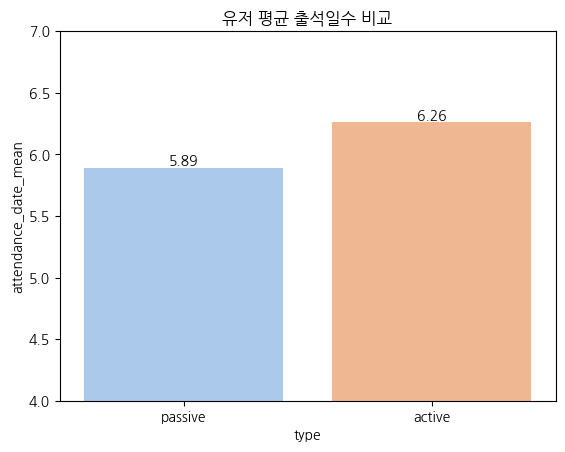

In [22]:
# 능동, 수동 유저 별 출석일수 비교
passive_attendance = funnel_attendance[funnel_attendance['user_id'].isin(question_passive_user)]
active_attendance = funnel_attendance[funnel_attendance['user_id'].isin(question_active_user)]

passive_attendance_counts = passive_attendance.groupby('user_id')['attendance_date_list'].count().reset_index(name='attendance_date_counts')
active_attendance_counts = active_attendance.groupby('user_id')['attendance_date_list'].count().reset_index(name='attendance_date_counts')

passive_attendance_counts_mean = passive_attendance_counts['attendance_date_counts'].mean()
active_attendance_counts_mean = active_attendance_counts['attendance_date_counts'].mean()

attendance_counts = pd.DataFrame({
    'type': ['passive', 'active'],
    'attendance_date_mean': [round(passive_attendance_counts_mean, 2), 
                             round(active_attendance_counts_mean, 2)]
})

# 출석 일수 별 차이 없었음
ax = sns.barplot(data=attendance_counts, x='type', y='attendance_date_mean', hue='type')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_title('유저 평균 출석일수 비교')
ax.set_ylim(4, 7)
plt.show()

In [120]:
def make_diff_column(df):
    new_df = pd.DataFrame({})
    for i in range(len(df)):
        df_slice = df.iloc[i: i+1] # df용
        df_slice_compare = df_slice.iloc[0] # 조건 비교용. 이렇게 안 하면 값이 index있는 df 형식으로 나옴
        
        if df_slice_compare['user_id'] == df_slice_compare['before_user_id']: # 이전행, 현재행의 user_id가 같으면
            diff = df_slice_compare['attendance_date_list'] - df_slice_compare['before_attendance_date'] # 날짜 차이 구함
            df_slice['diff'] = diff
        else: # 다르면
            df_slice['diff'] = np.nan # null 넣어줌
        
        new_df = pd.concat([new_df, df_slice])
    
    return new_df

# 1번만 출석한 유저는 제외 
passive_no_only_cond = passive_attendance_counts['attendance_date_counts'] > 1
active_no_only_cond = active_attendance_counts['attendance_date_counts'] > 1

passive_no_only_user = passive_attendance_counts[passive_no_only_cond]['user_id'].unique()
passive_attendance_diff = passive_attendance[passive_attendance['user_id'].isin(passive_no_only_user)]
passive_attendance_diff.sort_values(by=['user_id', 'attendance_date_list'], inplace=True)
passive_attendance_diff['before_attendance_date'] = passive_attendance_diff['attendance_date_list'].shift(1)
passive_attendance_diff['before_user_id'] = passive_attendance_diff['user_id'].shift(1)

active_no_only_user = active_attendance_counts[passive_no_only_cond]['user_id'].unique()
active_attendance_diff = active_attendance[active_attendance['user_id'].isin(active_no_only_user)]
active_attendance_diff.sort_values(by=['user_id', 'attendance_date_list'], inplace=True)
active_attendance_diff['before_attendance_date'] = active_attendance_diff['attendance_date_list'].shift(1)
active_attendance_diff['before_user_id'] = active_attendance_diff['user_id'].shift(1)

# 유저들의 평균 출석 기간 차이 df 생성
passive_attendance_diff = make_diff_column(passive_attendance_diff)
active_attendance_diff = make_diff_column(active_attendance_diff)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20736\3040651416.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  active_no_only_user = active_attendance_counts[passive_no_only_cond]['user_id'].unique()


In [ ]:
passive_attendance_diff_mean = passive_attendance_diff.groupby('user_id')['diff'].mean().reset_index()['diff'].mean()

Timedelta('6 days 20:46:59.351467567')

In [124]:
active_attendance_diff.groupby('user_id')['diff'].mean().reset_index()['diff'].mean()

Timedelta('6 days 05:42:05.268863574')

In [ ]:
# diff 그래프
passive_attendance_diff_mean = passive_attendance_diff.groupby('user_id')['diff'].mean().reset_index()
passive_attendance_diff_mean = passive_attendance_diff_mean['diff'].mean()

active_attendance_diff_mean = active_attendance_diff.groupby('user_id')['diff'].mean().reset_index()
active_attendance_diff_mean = active_attendance_diff_mean['diff'].mean()


### 포인트

In [13]:
# 능동, 수동 유저 별 포인트 수 비교
passive_accounts_user = funnel_user[funnel_user['user_id'].isin(question_passive_user)]
active_accounts_user = funnel_user[funnel_user['user_id'].isin(question_active_user)]

passive_point_describe = passive_accounts_user['point'].describe().reset_index(name='passive_points')
active_point_describe = active_accounts_user['point'].describe().reset_index(name='active_points')

# 포인트 describe는 별 차이 없음
# 굳이 따지면, max 차이
pd.merge(passive_point_describe, active_point_describe, on='index', how='left')

,index,passive_points,active_points
0,count,2289.000000,1705.000000
1,mean,1856.138488,1902.633431
2,std,2013.514332,2021.655629
3,min,4.000000,0.000000
4,25%,488.000000,465.000000
5,50%,1231.000000,1235.000000
6,75%,2503.000000,2643.000000
7,max,18803.000000,15951.000000


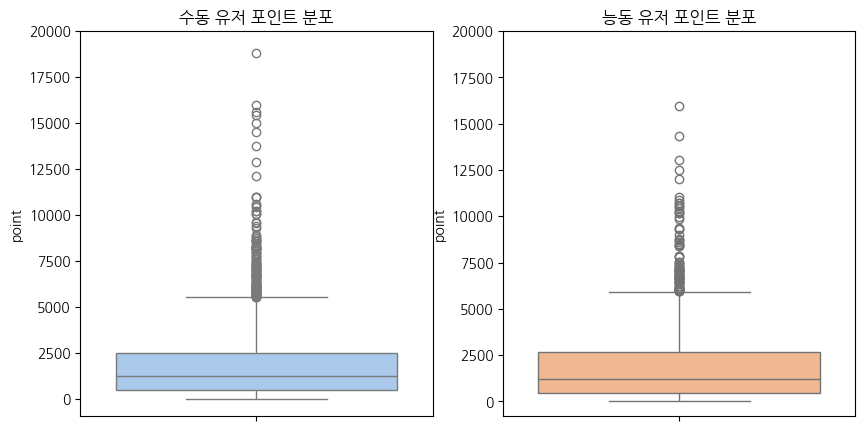

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0] = sns.boxplot(data=passive_accounts_user, y='point', ax=ax[0], color=passive_color)
ax[1] = sns.boxplot(data=active_accounts_user, y='point', ax=ax[1], color=active_color)

ax[0].set_title('수동 유저 포인트 분포')
ax[1].set_title('능동 유저 포인트 분포')

ax[0].set_yticks(range(0, 20001, 2500))
ax[1].set_yticks(range(0, 20001, 2500))
plt.show()

### 하트 구매 이력

In [15]:
# 능동, 수동 유저 별 구매이력 비교
passive_payment = funnel_payment[funnel_payment['user_id'].isin(question_passive_user)]
active_payment = funnel_payment[funnel_payment['user_id'].isin(question_active_user)]

passive_total_pay = passive_payment.groupby('user_id')['product_hearts'].sum().reset_index(name='total_pay_hearts')
active_total_pay = active_payment.groupby('user_id')['product_hearts'].sum().reset_index(name='total_pay_hearts')

passive_hearts_describe = passive_total_pay['total_pay_hearts'].describe().reset_index(name='passive_hearts')
active_hearts_describe = active_total_pay['total_pay_hearts'].describe().reset_index(name='active_hearts')

# 하트 총 구매 수에서, max부분에서 많이 차이가 남
pd.merge(passive_hearts_describe, active_hearts_describe, on='index', how='left')

,index,passive_hearts,active_hearts
0,count,459.000000,214.000000
1,mean,1417.002179,1260.500000
2,std,2630.790531,1298.907315
3,min,200.000000,200.000000
4,25%,777.000000,777.000000
5,50%,777.000000,777.000000
6,75%,977.000000,977.000000
7,max,44777.000000,10977.000000


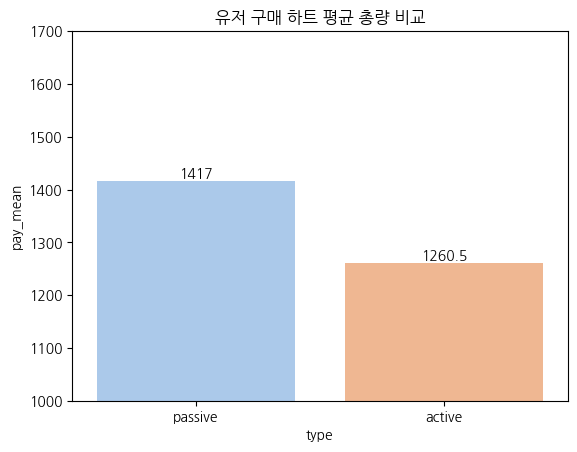

In [31]:
passive_total_pay_mean = passive_total_pay['total_pay_hearts'].mean()
active_total_pay_mean = active_total_pay['total_pay_hearts'].mean()

pay_mean = pd.DataFrame({
    'type': ['passive', 'active'],
    'pay_mean': [round(passive_total_pay_mean, 2), 
                round(active_total_pay_mean, 2)]
})

# 능동 유저들이 구매한 하트가 평균적으로 더 많았음
ax = sns.barplot(data=pay_mean, x='type', y='pay_mean', hue='type')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_title('유저 구매 하트 평균 총량 비교')
ax.set_ylim(1000, 1700)
plt.show()

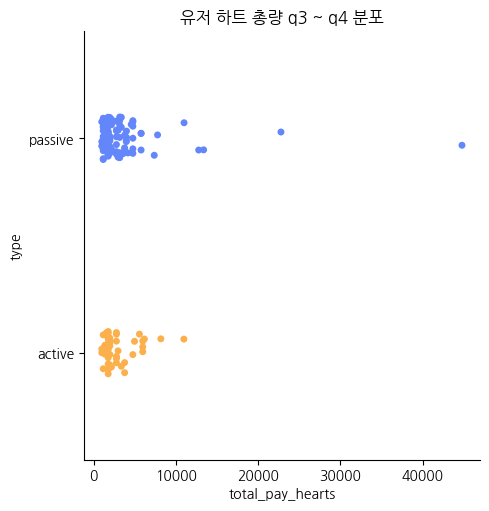

In [102]:
# 하트 75% ~ 비교
# np.percentile(passive_total_pay['total_pay_hearts'], 75)
passive_q3_pay = passive_total_pay[passive_total_pay['total_pay_hearts'] > 977]
active_q3_pay = active_total_pay[active_total_pay['total_pay_hearts'] > 977]

passive_q3_pay['type'] = 'passive'
active_q3_pay['type'] = 'active'

q3_pay = pd.concat([passive_q3_pay, active_q3_pay])

heart_colors = ["#6386fa", "#fcb04c"]
sns.catplot(data=q3_pay, x='total_pay_hearts', y='type', hue='type', palette=heart_colors)
plt.title('유저 하트 총량 q3 ~ q4 분포')
plt.show()

In [ ]:
# 해당 유저의 구매 여부 구분 함수
def is_pay(user, user_list):
    if user in user_list:
        return '구매'
    else:
        return '구매 X'

# 구매 유저 구하기
passive_pay_user = passive_total_pay['user_id'].unique()
active_pay_user = active_total_pay['user_id'].unique()
total_pay_user = funnel_payment['user_id'].unique()

# 유저 타입 별 구매 여부 df 생성
passive_is_pay = pd.DataFrame({
    'user_id': question_passive_user
})
active_is_pay = pd.DataFrame({
    'user_id': question_active_user
})

passive_is_pay['is_pay'] = passive_is_pay['user_id'].apply(lambda x: is_pay(x, passive_pay_user))
active_is_pay['is_pay'] = active_is_pay['user_id'].apply(lambda x: is_pay(x, active_pay_user))

passive_is_pay = passive_is_pay['is_pay'].value_counts().reset_index()
active_is_pay = active_is_pay['is_pay'].value_counts().reset_index()

# 전체 유저의 구매 여부 df (기간으로만 전처리한 전체 테이블)
funnel_pay_user_counts = len(funnel_user[funnel_user['user_id'].isin(total_pay_user)])
total_is_pay = pd.DataFrame({
    'is_pay': ['구매', '구매 X'],
    'count': [funnel_pay_user_counts,
              funnel_user['user_id'].nunique() - funnel_pay_user_counts]
})

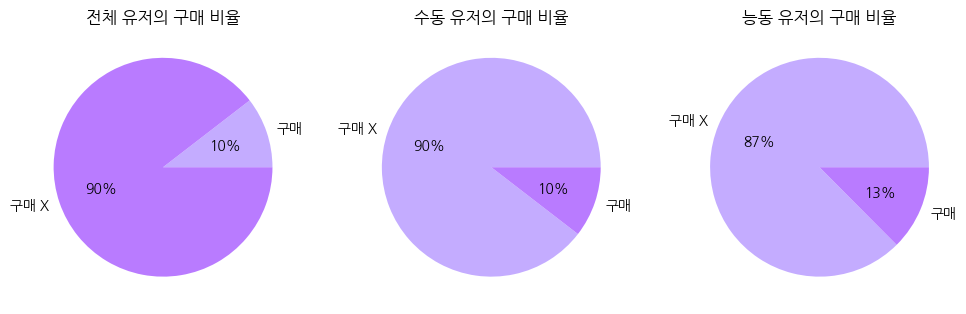

In [65]:
# 구매율 그래프
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
pay_colors = ["#c4acff", "#b97bff"]
ax[0].pie(x=total_is_pay['count'], labels=total_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)
ax[1].pie(x=passive_is_pay['count'], labels=passive_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)
ax[2].pie(x=active_is_pay['count'], labels=active_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)

ax[0].set_title('전체 유저의 구매 비율')
ax[1].set_title('수동 유저의 구매 비율')
ax[2].set_title('능동 유저의 구매 비율')

plt.show()

# 수동유저의 구매 비율이 생각보다 낮음
# 구매 총량은 많았는데..?
# 수동유저는 한 사람이 여러번 사는 경우가 많았나봄